In [48]:
# ---- Reproducibility
import random
import torch
import sys
import os
import matplotlib.pyplot as plt
from cebmf_torch import cEBMF
#seed = 1234
#random.seed(seed)
#torch.manual_seed(seed)
#if torch.cuda.is_available():
#    torch.cuda.manual_seed_all(seed)


In [49]:
from cebmf_torch.torch_main import normal_means_loglik

In [50]:


# ---- Parameters
n, p = 50, 40
noise_std = 0.1

# (Optional) choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Data generation (PyTorch)
# Use float64 to mirror NumPy defaults
u = torch.rand(n, dtype=torch.float64, device=device)          # length n
v = torch.rand(p, dtype=torch.float64, device=device)          # length p

# Rank-1 matrix via outer product
rank_1_matrix = torch.outer(u, v)                              # (n, p)

# Homoscedastic Gaussian noise
noise = noise_std * torch.randn(n, p, dtype=torch.float64, device=device)

noisy_matrix = rank_1_matrix + noise

# ---- Print (move to CPU for readability if needed)
print("Rank-1 Matrix (Outer Product):")
print(rank_1_matrix.cpu().numpy())

print("\nNoisy Matrix (with Homoscedastic Noise):")
print(noisy_matrix.cpu().numpy())


Rank-1 Matrix (Outer Product):
[[0.10183198 0.04179437 0.02419357 ... 0.15857383 0.20969895 0.17719393]
 [0.37269712 0.15296413 0.0885466  ... 0.58036789 0.76748184 0.64851601]
 [0.23915893 0.09815675 0.05682016 ... 0.3724208  0.49249141 0.4161513 ]
 ...
 [0.34951133 0.14344811 0.08303804 ... 0.54426273 0.71973616 0.6081713 ]
 [0.08165583 0.03351358 0.01940006 ... 0.12715532 0.16815093 0.14208619]
 [0.03996504 0.01640264 0.00949502 ... 0.06223398 0.08229857 0.06954164]]

Noisy Matrix (with Homoscedastic Noise):
[[ 0.09951602  0.02614354 -0.16815235 ...  0.28284187  0.27875396
   0.05413766]
 [ 0.26044719  0.30674842  0.18253977 ...  0.51981395  0.8529362
   0.76356992]
 [ 0.23443733  0.07428488 -0.04053495 ...  0.40685807  0.56206996
   0.31545154]
 ...
 [ 0.49719097  0.04818408  0.13564272 ...  0.61150795  0.62623968
   0.60111502]
 [-0.00615284  0.03337321  0.03377152 ...  0.06712921  0.11190382
   0.03189209]
 [-0.10464407 -0.11992216  0.32517501 ...  0.1760092   0.10745593
   0.139

In [51]:
mycebmf=  cEBMF(data= noisy_matrix) 
mycebmf.initialize()
print(mycebmf.L[:,1])
print(mycebmf.F[:,1])

tensor([-0.0147, -0.2760, -0.0662,  0.0625,  0.0772,  0.0047,  0.0633,  0.0280,
        -0.3390, -0.0413, -0.0170,  0.0669,  0.1766, -0.2237, -0.0968,  0.0988,
        -0.0460,  0.0924,  0.0023,  0.1061,  0.2991,  0.2363,  0.3222,  0.1686,
        -0.0574, -0.1355, -0.1192,  0.2116,  0.3235,  0.0218, -0.0371,  0.0350,
        -0.0155,  0.2007,  0.0133, -0.2813, -0.0676,  0.0023,  0.2820, -0.0249,
        -0.4599, -0.1258,  0.1396, -0.2020,  0.1928,  0.3024,  0.0350,  0.0207,
        -0.1874,  0.3040])
tensor([ 0.0081, -0.0964,  0.2163,  0.0418, -0.0567, -0.0518, -0.0031, -0.1564,
        -0.0869, -0.0970,  0.0351, -0.2561, -0.1230,  0.1926, -0.3042, -0.2442,
        -0.0405,  0.1762,  0.1268, -0.0604,  0.3845,  0.0120,  0.1653, -0.2584,
        -0.0922,  0.0957,  0.0962,  0.0341, -0.2715,  0.3153,  0.0100,  0.0928,
         0.0382,  0.0887,  0.0398, -0.0994,  0.1395,  0.2355, -0.0932,  0.1214])


In [52]:
tau_map=None
eps = 1e-12

In [53]:
k = 0

Rk = mycebmf._partial_residual_masked(k)  # (N,P), zeros where missing
fk = mycebmf.F[:, k]  # (P,)
fk2 = mycebmf.F2[:, k]  # (P,)

if tau_map is None:
    denom_l = (
        (fk2.view(1, -1) * mycebmf.mask).sum(dim=1).clamp_min(eps)
    )  # (N,)
    num_l = Rk @ fk  # (N,)
    se_l = torch.sqrt(1.0 / (mycebmf.tau * denom_l))
else:
    denom_l = (
        (tau_map * (fk2.view(1, -1) * mycebmf.mask)).sum(dim=1).clamp_min(eps)
    )  # (N,)
    num_l = (tau_map * Rk) @ fk  # (N,)
    se_l = torch.sqrt(1.0 / denom_l)

lhat = num_l / denom_l
# print(denom_l)

X_model = mycebmf.update_cov_L(k)
with torch.enable_grad():
    resL = mycebmf.prior_L_fn(
        X=X_model,
        betahat=lhat,
        sebetahat=se_l,
        model_param=mycebmf.model_state_L[k],
    )
with torch.no_grad():
    mycebmf.model_state_L[k] = resL.model_param
    mycebmf.L[:, k] = resL.post_mean
    mycebmf.L2[:, k] = resL.post_mean2
    nm_ll_L = normal_means_loglik(
        x=lhat, s=se_l, Et=resL.post_mean, Et2=resL.post_mean2
    )
    mycebmf.kl_l[k] = torch.as_tensor((-resL.loss) - nm_ll_L, device=mycebmf.device)
    mycebmf.pi0_L[k] = resL.pi0_null if hasattr(resL, "pi0_null") else None

# ---------- Update F[:, k] ----------
Rk = mycebmf._partial_residual_masked(k)  # recompute with updated L
lk = mycebmf.L[:, k]  # (N,)
lk2 = mycebmf.L2[:, k]  # (N,)

if tau_map is None:
    denom_f = (
        (lk2.view(-1, 1) * mycebmf.mask).sum(dim=0).clamp_min(eps)
    )  # (P,)
    num_f = Rk.T @ lk  # (P,)
    se_f = torch.sqrt(1.0 / (mycebmf.tau * denom_f))
else:
    denom_f = (
        (tau_map * (lk2.view(-1, 1) * mycebmf.mask)).sum(dim=0).clamp_min(eps)
    )  # (P,)
    num_f = (tau_map * Rk).T @ lk  # (P,)
    se_f = torch.sqrt(1.0 / denom_f)

fhat = num_f / denom_f

X_model = mycebmf.update_cov_F(k)
with torch.enable_grad():
    resF = mycebmf.prior_F_fn(
        X=X_model,
        betahat=fhat,
        sebetahat=se_f,
        model_param=mycebmf.model_state_F[k],
    )
with torch.no_grad():
    mycebmf.model_state_F[k] = resF.model_param
    mycebmf.F[:, k] = resF.post_mean
    mycebmf.F2[:, k] = resF.post_mean2
    # store as scalar on device; PriorResult.loss already = -log_lik
    nm_ll_F = normal_means_loglik(
        x=fhat, s=se_f, Et=resF.post_mean, Et2=resF.post_mean2
    )
    mycebmf.kl_f[k] = torch.as_tensor((-resF.loss) - nm_ll_F, device=mycebmf.device)
    mycebmf.pi0_F[k] = resF.pi0_null if hasattr(resF, "pi0_null") else None


In [ ]:
mycebmf=  cEBMF(data= noisy_matrix) 
mycebmf.initialize()


5


In [70]:
mycebmf.iter_once()

Converged after 66 iterations.
Converged after 54 iterations.
2


In [55]:
mycebmf0=  cEBMF(data= noisy_matrix) 
mycebmf0.initialize()
print(mycebmf0.L[:,1])
print(mycebmf0.F[:,1])

tensor([-0.0147, -0.2760, -0.0662,  0.0625,  0.0772,  0.0047,  0.0633,  0.0280,
        -0.3390, -0.0413, -0.0170,  0.0669,  0.1766, -0.2237, -0.0968,  0.0988,
        -0.0460,  0.0924,  0.0023,  0.1061,  0.2991,  0.2363,  0.3222,  0.1686,
        -0.0574, -0.1355, -0.1192,  0.2116,  0.3235,  0.0218, -0.0371,  0.0350,
        -0.0155,  0.2007,  0.0133, -0.2813, -0.0676,  0.0023,  0.2820, -0.0249,
        -0.4599, -0.1258,  0.1396, -0.2020,  0.1928,  0.3024,  0.0350,  0.0207,
        -0.1874,  0.3040])
tensor([ 0.0081, -0.0964,  0.2163,  0.0418, -0.0567, -0.0518, -0.0031, -0.1564,
        -0.0869, -0.0970,  0.0351, -0.2561, -0.1230,  0.1926, -0.3042, -0.2442,
        -0.0405,  0.1762,  0.1268, -0.0604,  0.3845,  0.0120,  0.1653, -0.2584,
        -0.0922,  0.0957,  0.0962,  0.0341, -0.2715,  0.3153,  0.0100,  0.0928,
         0.0382,  0.0887,  0.0398, -0.0994,  0.1395,  0.2355, -0.0932,  0.1214])


In [56]:
R = mycebmf0.Y0 - mycebmf0.L @ mycebmf0.F.T

In [57]:
k= 0 


In [58]:
# Precondition: R is the global residual with ALL components removed:
# R = Y - sum_j L[:, j] @ F[:, j]^T

for k in range(mycebmf0.K):
    # 1) Add back k's current contribution to form the partial residual
    R_k = R + torch.outer(mycebmf0.L[:, k], mycebmf0.F[:, k])  # (N,P)

    # ---------- Update L[:, k] (hold F[:, k] fixed) ----------
    fk  = mycebmf0.F[:, k]      # (P,)
    fk2 = mycebmf0.F2[:, k]     # (P,)

    if tau_map is None:
        denom_l = ((fk2.view(1, -1) * mycebmf0.mask).sum(dim=1).clamp_min(eps))  # (N,)
        num_l   = R_k @ fk                                                        # (N,)
        se_l    = torch.sqrt(1.0 / (mycebmf0.tau * denom_l))
    else:
        denom_l = ((tau_map * (fk2.view(1, -1) * mycebmf0.mask)).sum(dim=1).clamp_min(eps))  # (N,)
        num_l   = (tau_map * R_k) @ fk                                                        # (N,)
        se_l    = torch.sqrt(1.0 / denom_l)

    lhat = num_l / denom_l

    X_model = mycebmf0.update_cov_L(k)
    with torch.enable_grad():
        resL = mycebmf0.prior_L_fn(
            X=X_model, betahat=lhat, sebetahat=se_l, model_param=mycebmf0.model_state_L[k],
        )
    with torch.no_grad():
        mycebmf0.model_state_L[k] = resL.model_param
        mycebmf0.L[:, k]  = resL.post_mean
        mycebmf0.L2[:, k] = resL.post_mean2
        nm_ll_L = normal_means_loglik(x=lhat, s=se_l, Et=resL.post_mean, Et2=resL.post_mean2)
        mycebmf0.kl_l[k] = torch.as_tensor((-resL.loss) - nm_ll_L, device=mycebmf0.device)
        mycebmf0.pi0_L[k] = resL.pi0_null if hasattr(resL, "pi0_null") else None

    # 2) Recompute global residual with UPDATED L[:, k] (F[:, k] still old)
    R = R_k - torch.outer(mycebmf0.L[:, k], mycebmf0.F[:, k])

    # 3) Add back k's (now with updated L) to update F
    R_k = R + torch.outer(mycebmf0.L[:, k], mycebmf0.F[:, k])

    # ---------- Update F[:, k] (hold UPDATED L[:, k] fixed) ----------
    lk  = mycebmf0.L[:, k]      # (N,)
    lk2 = mycebmf0.L2[:, k]     # (N,)

    if tau_map is None:
        denom_f = ((lk2.view(-1, 1) * mycebmf0.mask).sum(dim=0).clamp_min(eps))  # (P,)
        num_f   = R_k.T @ lk                                                     # (P,)
        se_f    = torch.sqrt(1.0 / (mycebmf0.tau * denom_f))
    else:
        denom_f = ((tau_map * (lk2.view(-1, 1) * mycebmf0.mask)).sum(dim=0).clamp_min(eps))  # (P,)
        num_f   = (tau_map * R_k).T @ lk                                                     # (P,)
        se_f    = torch.sqrt(1.0 / denom_f)

    fhat = num_f / denom_f

    X_model = mycebmf0.update_cov_F(k)
    with torch.enable_grad():
        resF = mycebmf0.prior_F_fn(
            X=X_model, betahat=fhat, sebetahat=se_f, model_param=mycebmf0.model_state_F[k],
        )
    with torch.no_grad():
        mycebmf0.model_state_F[k] = resF.model_param
        mycebmf0.F[:, k]  = resF.post_mean
        mycebmf0.F2[:, k] = resF.post_mean2
        nm_ll_F = normal_means_loglik(x=fhat, s=se_f, Et=resF.post_mean, Et2=resF.post_mean2)
        mycebmf0.kl_f[k] = torch.as_tensor((-resF.loss) - nm_ll_F, device=mycebmf0.device)
        mycebmf0.pi0_F[k] = resF.pi0_null if hasattr(resF, "pi0_null") else None

    # 4) Recompute global residual with UPDATED F[:, k]
    R = R_k - torch.outer(mycebmf0.L[:, k], mycebmf0.F[:, k])


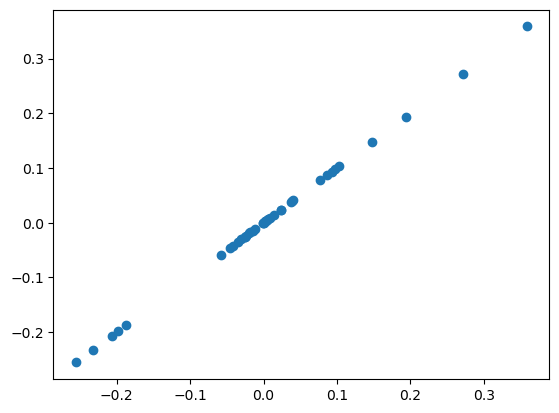

In [59]:
plt.scatter(mycebmf0.F[:, 1],mycebmf.F[:, 1 ])

In [76]:
# R is the global residual with ALL components removed:
# R = Y - sum_j L[:, j] @ F[:, j]^T

for k in range(mycebmf0.K):
    Lk  = mycebmf0.L[:, k]
    Fk  = mycebmf0.F[:, k]
    Lk2 = mycebmf0.L2[:, k]
    Fk2 = mycebmf0.F2[:, k]

    # ---- Add back k's contribution: R <- R + Lk Fk^T (in-place, no outer allocation)
    R.addr_(Lk, Fk, alpha=1.0)

    # ---------- Update L[:, k] ----------
    if tau_map is None:
        # denom_l = sum_j mask[i,j] * Fk2[j]
        denom_l = mycebmf0.mask @ Fk2
        # num_l = (R @ Fk)
        num_l   = R @ Fk
        se_l    = torch.sqrt(1.0 / (mycebmf0.tau * denom_l.clamp_min(eps)))
    else:
        # denom_l = sum_j tau_map[i,j]*mask[i,j]*Fk2[j]
        denom_l = (tau_map * mycebmf0.mask) @ Fk2
        # num_l = sum_j tau_map[i,j]*R[i,j]*Fk[j]
        num_l   = torch.einsum('ij,ij,j->i', R, tau_map, Fk)
        se_l    = torch.sqrt(1.0 / denom_l.clamp_min(eps))

    lhat = num_l / denom_l.clamp_min(eps)

    X_model = mycebmf0.update_cov_L(k)
    with torch.enable_grad():
        resL = mycebmf0.prior_L_fn(
            X=X_model, betahat=lhat, sebetahat=se_l, model_param=mycebmf0.model_state_L[k]
        )
    with torch.no_grad():
        mycebmf0.model_state_L[k] = resL.model_param
        mycebmf0.L[:, k]  = resL.post_mean
        mycebmf0.L2[:, k] = resL.post_mean2
        nm_ll_L = normal_means_loglik(x=lhat, s=se_l, Et=resL.post_mean, Et2=resL.post_mean2)
        mycebmf0.kl_l[k]  = torch.as_tensor((-resL.loss) - nm_ll_L, device=mycebmf0.device)
        mycebmf0.pi0_L[k] = resL.pi0_null if hasattr(resL, "pi0_null") else None

    # ---- Subtract UPDATED Lk contribution: R <- R - Lk_new Fk^T
    Lk = mycebmf0.L[:, k]  # updated
    R.addr_(Lk, Fk, alpha=-1.0)

    # ---- Add back (updated Lk) to prepare F update: R <- R + Lk_new Fk^T
    R.addr_(Lk, Fk, alpha=1.0)

    # ---------- Update F[:, k] ----------
    if tau_map is None:
        # denom_f = sum_i mask[i,j] * Lk2[i]
        denom_f = mycebmf0.mask.T @ mycebmf0.L2[:, k]
        # num_f = (R^T @ Lk)
        num_f   = R.T @ Lk
        se_f    = torch.sqrt(1.0 / (mycebmf0.tau * denom_f.clamp_min(eps)))
    else:
        # denom_f = sum_i tau_map[i,j]*mask[i,j]*Lk2[i]
        denom_f = (tau_map * mycebmf0.mask).transpose(0, 1) @ mycebmf0.L2[:, k]
        # num_f = sum_i tau_map[i,j]*R[i,j]*Lk[i]
        num_f   = torch.einsum('ij,ij,i->j', R, tau_map, Lk)
        se_f    = torch.sqrt(1.0 / denom_f.clamp_min(eps))

    fhat = num_f / denom_f.clamp_min(eps)

    X_model = mycebmf0.update_cov_F(k)
    with torch.enable_grad():
        resF = mycebmf0.prior_F_fn(
            X=X_model, betahat=fhat, sebetahat=se_f, model_param=mycebmf0.model_state_F[k]
        )
    with torch.no_grad():
        mycebmf0.model_state_F[k] = resF.model_param
        mycebmf0.F[:, k]  = resF.post_mean
        mycebmf0.F2[:, k] = resF.post_mean2
        nm_ll_F = normal_means_loglik(x=fhat, s=se_f, Et=resF.post_mean, Et2=resF.post_mean2)
        mycebmf0.kl_f[k]  = torch.as_tensor((-resF.loss) - nm_ll_F, device=mycebmf0.device)
        mycebmf0.pi0_F[k] = resF.pi0_null if hasattr(resF, "pi0_null") else None

    # ---- Subtract UPDATED Fk contribution: R <- R - Lk_new Fk_new^T
    Fk = mycebmf0.F[:, k]  # updated
    R.addr_(Lk, Fk, alpha=-1.0)


Converged after 65 iterations.
Converged after 54 iterations.


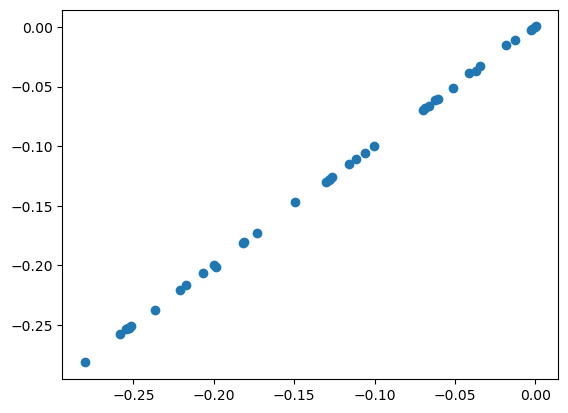

In [78]:
plt.scatter(mycebmf0.F[:, 0],mycebmf.F[:, 0 ])